# DMS - Data Analysis

In [1]:
import os
import pandas as pd
from abag_affinity.utils.config import read_config, get_data_paths
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

config = read_config("../../config.yaml")
summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], config["DATASETS"]["DMS"]["summary"])

In [2]:
publications = os.listdir(os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"]))
publications = [ ".".join(pub.split(".")[:-1]) for pub in publications if ".csv" in pub]
publications

['madan21_mutat_hiv',
 'mason21_comb_optim_therap_antib_by_predic_combined_H3_3',
 'wu20_differ_ha_h3_h1',
 'taft22_deep_mutat_learn_predic_ace2',
 'b.20_funct_screen_strat_engin_chimer',
 'phillips21_bindin',
 'mason21_optim_therap_antib_by_predic_dms_H',
 'mason21_comb_optim_therap_antib_by_predic_combined_L3_3',
 'wu17_in',
 'starr21_prosp_covid',
 'mason21_optim_therap_antib_by_predic_dms_L']

In [3]:
full_dms_df = pd.read_csv(os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["DMS"]["folder_path"], config["RESOURCES"]["DMS"]["info"]))
full_dms_df = full_dms_df[~full_dms_df["publication"].isin(["mason21_comb_optim_therap_antib_by_predic_combined_H3_2", "mason21_comb_optim_therap_antib_by_predic_combined_H3_1"])]


all_complexes = full_dms_df.groupby(["publication", "antibody", "antigen"])

In [4]:
dfs = []
for publication in publications:
    df = pd.read_csv(os.path.join(config["DATASETS"]["path"], config["DATASETS"]["DMS"]["folder_path"], f"{publication}.csv"), index_col=0)
    dfs.append(df)

    
dms_df = pd.concat(dfs)

In [5]:
dms_df[["publication", "antibody", "antigen"]] = dms_df["pdb"].str.split(':', 2, expand=True)

In [6]:
dms_df = dms_df.reset_index(drop=True)

In [7]:
complexes = dms_df.groupby(["publication", "antibody", "antigen"])

In [8]:
# add also not generated complexes
complexes_not_generated = set(all_complexes.groups.keys()) - set(complexes.groups.keys())
complexes_not_generated_df = pd.DataFrame(complexes_not_generated, columns=["publication", "antibody", "antigen"])
complexes_not_generated_df["mutation_code"] = ""

generated_complexes_count = pd.concat([
    complexes["mutation_code"].count(),
    complexes_not_generated_df.groupby(["publication", "antibody", "antigen"])["mutation_code"].count()
]).sort_index()

In [9]:
generated_complexes_count

publication                                              antibody     antigen   
b.20_funct_screen_strat_engin_chimer                     trastuzumab  her2             200
madan21_mutat_hiv                                        vfp1602      fp8v1           4308
                                                                      fp8v2           4308
mason21_comb_optim_therap_antib_by_predic_combined_H3_3  trastuzumab  her2           11306
mason21_comb_optim_therap_antib_by_predic_combined_L3_3  trastuzumab  her2             186
mason21_optim_therap_antib_by_predic_dms_H               trastuzumab  her2             695
mason21_optim_therap_antib_by_predic_dms_L               trastuzumab  her2             341
phillips21_bindin                                        cr6261       h1newcal99      1887
                                                                      h9hk99          1842
                                                         cr9114       h1newcal99     65094
         

### Number of mutations for complex

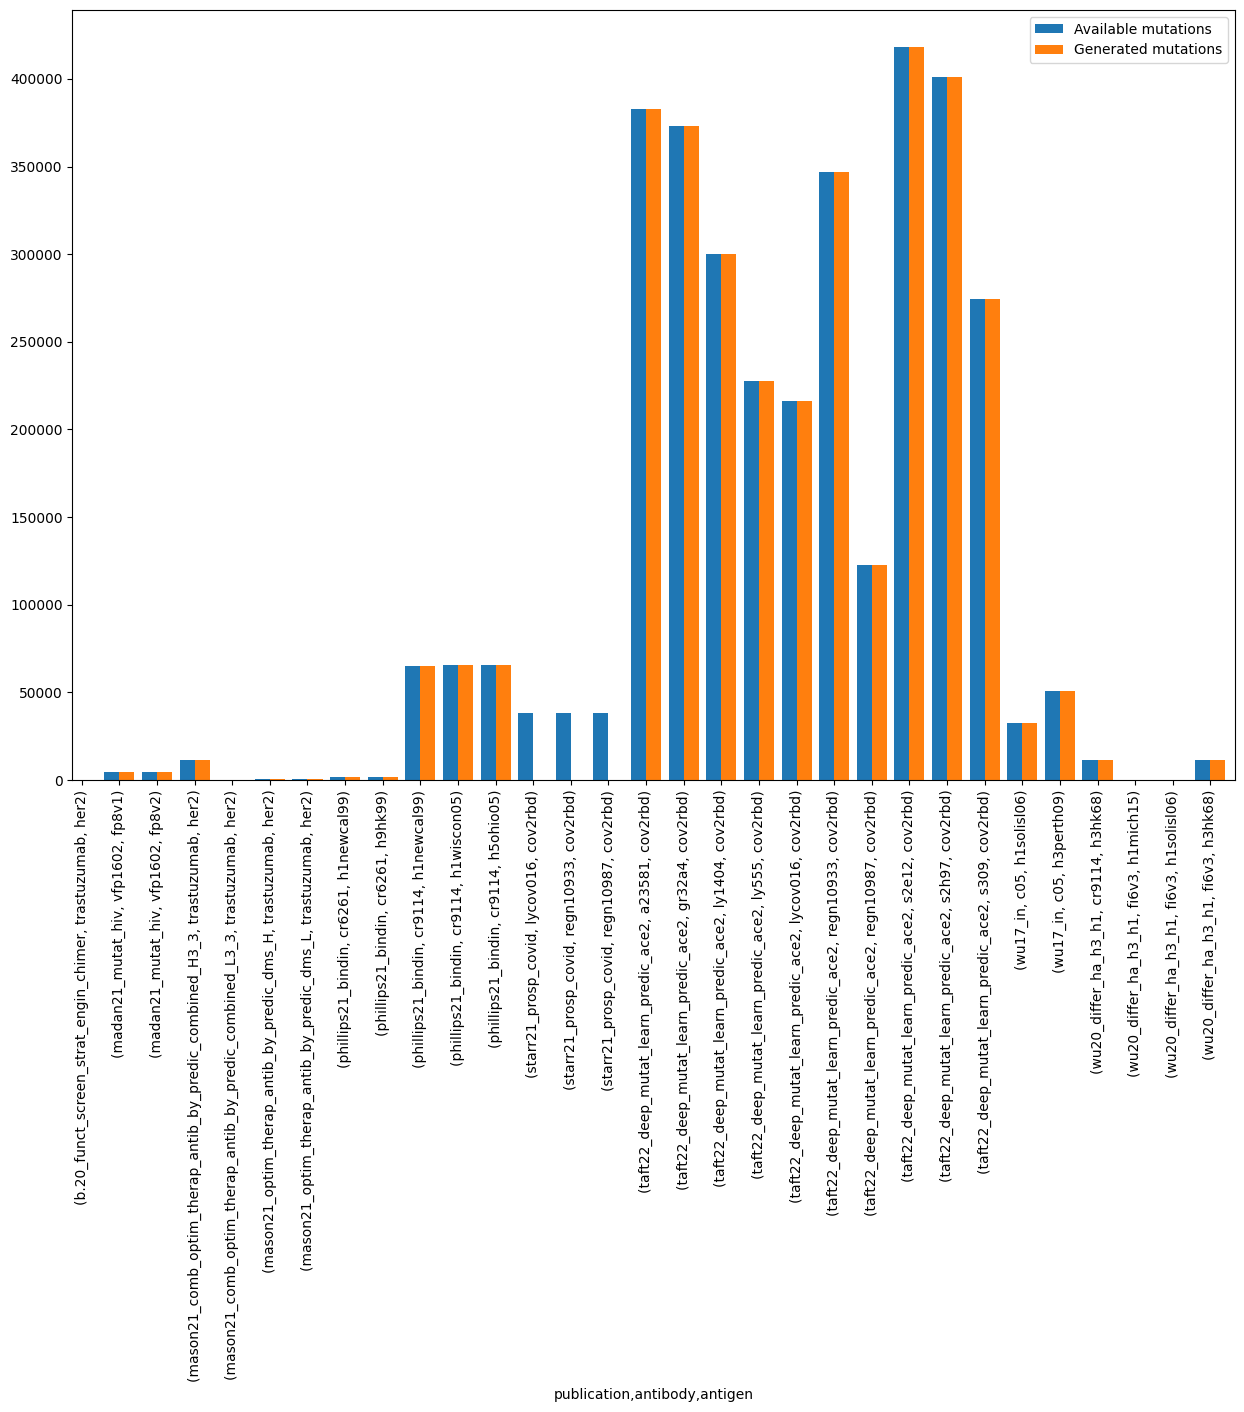

In [10]:
colors = sns.color_palette()
# check if all data points are available
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111) 

width = 0.4

all_complexes["mutation_code"].count().plot(kind="bar", ax=ax, width=width, position=1, color=colors[0], label="Available mutations")
generated_complexes_count.plot(kind="bar", ax=ax, width=width, position=0, label="Generated mutations", color=colors[1])

plt.legend()
plt.show()

<AxesSubplot:ylabel='publication,antibody,antigen'>

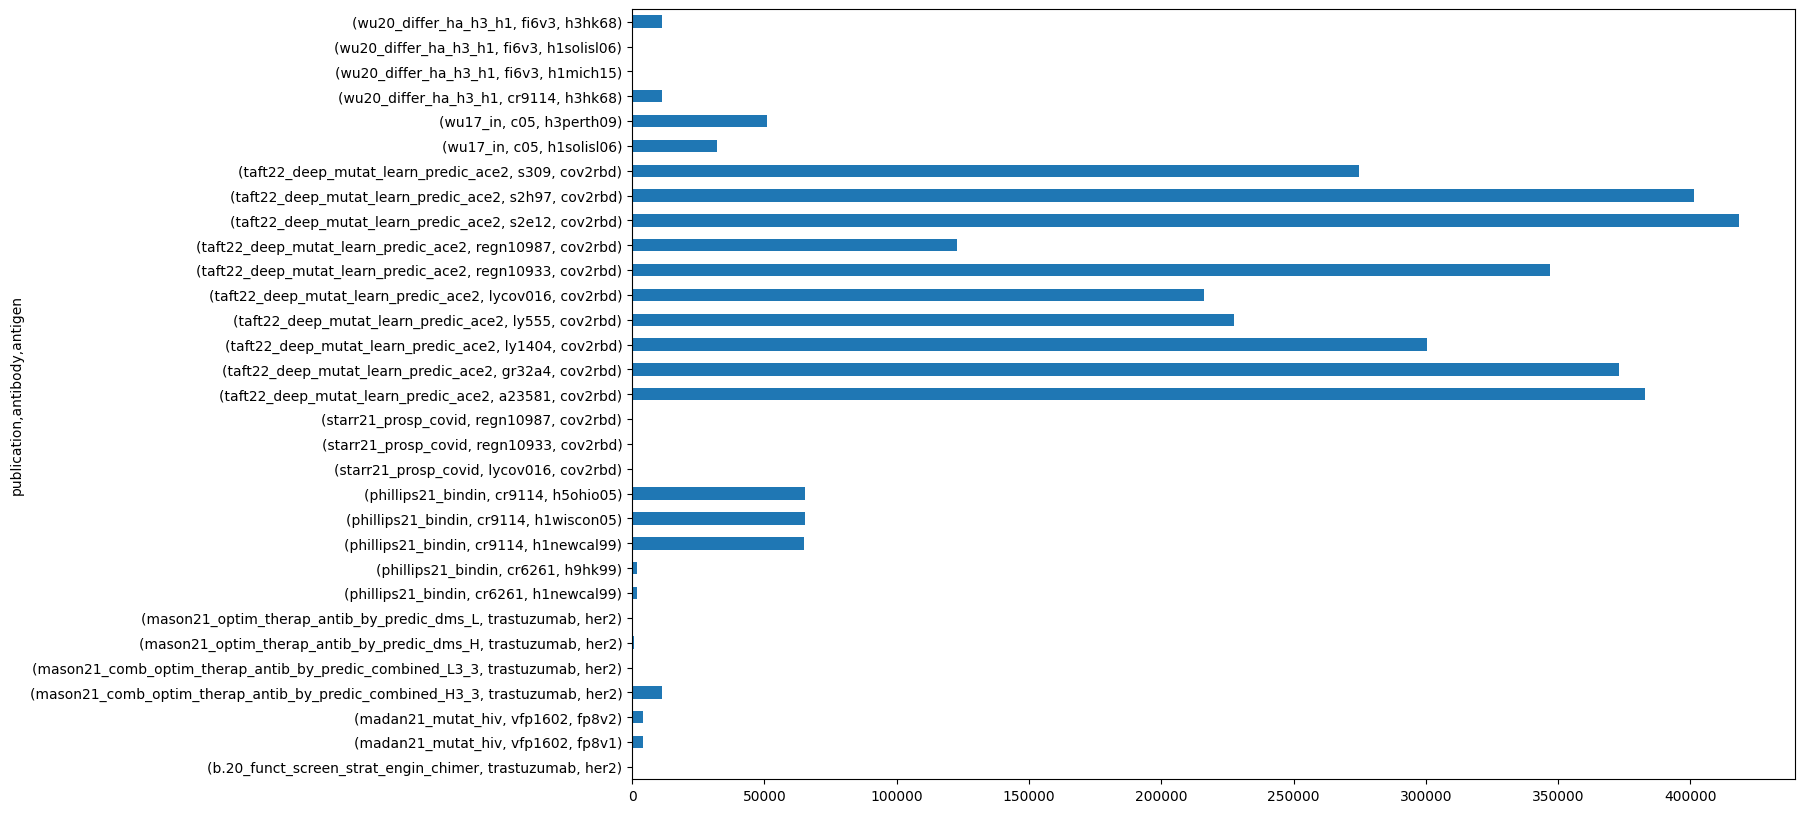

In [11]:
complexes["mutation_code"].count().plot(kind="barh", figsize=(15, 10))

## Distribution of affinity values

In [33]:
for col in ["-log(Kd)","E"]:
    print(col)
    
    publication_counts = defaultdict(int)

    for group, idx in complexes.groups.items():
        group_df = dms_df.iloc[idx]

        if any(group_df[col].notnull()):
            publication_counts[group[0]] += sum(group_df[col].notnull())
            
    for publication, count in publication_counts.items():
        print(count, "\t:", publication)
    print()

-log(Kd)
23 	: madan21_mutat_hiv
11 	: mason21_comb_optim_therap_antib_by_predic_combined_H3_3
199892 	: phillips21_bindin
8 	: wu17_in
48 	: wu20_differ_ha_h3_h1

E
200 	: b.20_funct_screen_strat_engin_chimer
8616 	: madan21_mutat_hiv
11306 	: mason21_comb_optim_therap_antib_by_predic_combined_H3_3
186 	: mason21_comb_optim_therap_antib_by_predic_combined_L3_3
695 	: mason21_optim_therap_antib_by_predic_dms_H
341 	: mason21_optim_therap_antib_by_predic_dms_L
6 	: starr21_prosp_covid
3063077 	: taft22_deep_mutat_learn_predic_ace2
83285 	: wu17_in
22778 	: wu20_differ_ha_h3_h1



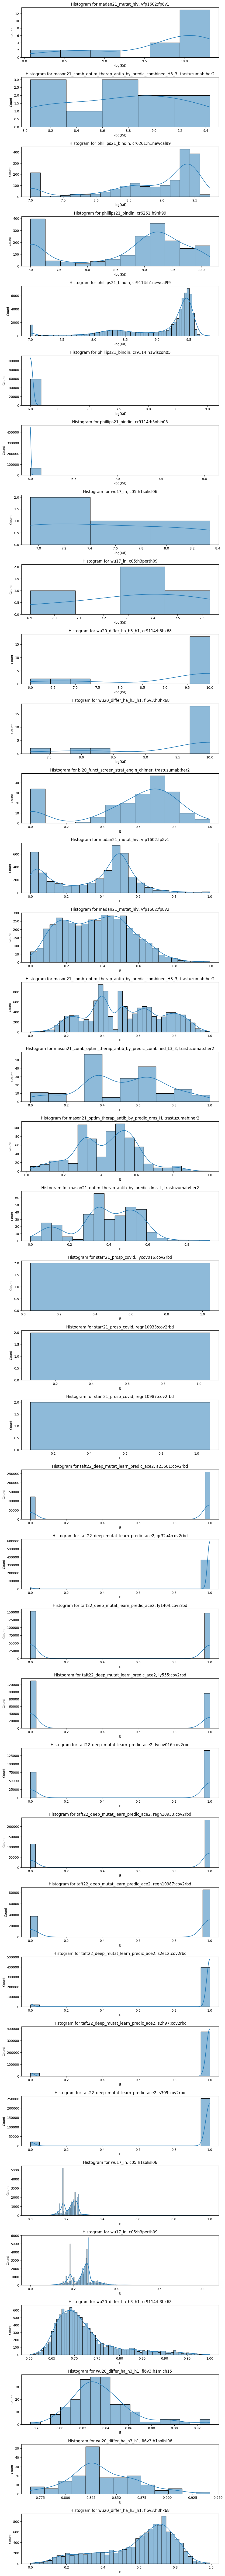

In [13]:
fig, axs = plt.subplots(figsize=(10,37 * 3), nrows=37)
fig.tight_layout(pad=4.0)

i = 0

for col in ["-log(Kd)","E"]:

    for group, idx in complexes.groups.items():
        group_df = dms_df.iloc[idx]

        if any(group_df[col].notnull()):

            sns.histplot(group_df, x=col, kde=True, ax=axs[i]).set_title(f"Histogram for {group[0]}, {group[1]}:{group[2]}")
            
            wt_values = group_df.loc[group_df["mutation_code"].isna(), col].values
            if len(wt_values) > 0:
                for wt_value in wt_values:
                    if not np.isnan(wt_value):
                        axs[i].axvline(wt_value, color="red")
            i += 1


## Error analysis of generation process

In [14]:
generation_log_path = os.path.join(config["DATASETS"]["path"], 
                                   config["DATASETS"]["DMS"]["folder_path"], 
                                   config["DATASETS"]["DMS"]["mutated_pdb_path"],
                                  "{}/{}_{}.logs")


In [15]:
all_logs = []
nologs = []

for group, idx in complexes.groups.items():
    publication, antibody, antigen = group
    group_log_path = generation_log_path.format(publication, antibody, antigen)
    if os.path.exists(group_log_path):
        group_logs = pd.read_csv(group_log_path)
        group_logs["publication"] = publication
        group_logs["antibody"] = antibody
        group_logs["antigen"] = antigen
        all_logs.append(group_logs)
    else:
        print(f"No logs available for {publication}:{antibody}:{antigen}")
        nologs.append(f"{publication}:{antibody}:{antigen}")
        
all_logs = pd.concat(all_logs)
all_logs.reset_index(inplace=True, drop=True)


/home/fabian/miniconda3/envs/DeepRefine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
publications = dms_df.groupby("publication")
for publication, idx in publications.groups.items():
    print(len(dms_df.iloc[idx]["mutation_code"].unique()), ":", publication)
    print()

191 : b.20_funct_screen_strat_engin_chimer

527 : madan21_mutat_hiv

11306 : mason21_comb_optim_therap_antib_by_predic_combined_H3_3

186 : mason21_comb_optim_therap_antib_by_predic_combined_L3_3

695 : mason21_optim_therap_antib_by_predic_dms_H

341 : mason21_optim_therap_antib_by_predic_dms_L

9181 : phillips21_bindin

1 : starr21_prosp_covid

1594539 : taft22_deep_mutat_learn_predic_ace2

74717 : wu17_in

5677 : wu20_differ_ha_h3_h1



In [17]:
all_mut = (dms_df["mutation_code"] == dms_df["original_mutation"]).sum()
print(f"In total {all_mut:,} of {len(dms_df):,} jobs have complete mutations ")


different_mut = ((dms_df["mutation_code"] != dms_df["original_mutation"]) & ~dms_df["mutation_code"].isna() & (dms_df["mutation_code"] != "original")).sum()
print(f"In total {different_mut:,} of {len(dms_df):,} jobs have different mutations ")


original = ((dms_df["mutation_code"] == "original")).sum()
print(f"In total {original:,} of {len(dms_df):,} jobs are original pdb (no mutation)")


no_mut = (dms_df["mutation_code"].isna() | (dms_df["mutation_code"] == "original")).sum()
print(f"In total {no_mut:,} of {len(dms_df):,} jobs have no mutations ")


unique_data_points = len(dms_df.groupby("pdb").groups.keys())
print(f"In total {unique_data_points:,} of {len(dms_df):,} are unique pdbs ")


print()

some_mut = ((dms_df["mutation_code"] != "original") &  (~dms_df["mutation_code"].isna()) ).sum()
print(f"In total {some_mut:,} of {len(dms_df):,} jobs have some mutations (all or only a part)")

In total 545,637 of 3,390,382 jobs have complete mutations 
In total 2,472,694 of 3,390,382 jobs have different mutations 
In total 372,051 of 3,390,382 jobs are original pdb (no mutation)
In total 372,051 of 3,390,382 jobs have no mutations 
In total 31 of 3,390,382 are unique pdbs 

In total 3,018,331 of 3,390,382 jobs have some mutations (all or only a part)


In [18]:
dms_df["code"] = dms_df.apply(lambda row: ":".join([row["publication"], row["antibody"], row["antigen"] ]), axis=1)

In [19]:
print("Info for all logs available:", len(dms_df[~dms_df["code"].isin(nologs)]) == len(all_logs))

all_mut = (all_logs["mutation_code"] == all_logs["performed_mutations"]).sum()
print(f"In total {all_mut:,} of {len(all_logs):,} jobs have complete mutations ")


different_mut = ((all_logs["mutation_code"] != all_logs["performed_mutations"]) & ~all_logs["performed_mutations"].isna() & ((all_logs["status"] == "processed") | (all_logs["status"] == "already_processed")) & (all_logs["performed_mutations"] != "[]")).sum()
print(f"In total {different_mut:,} of {len(all_logs):,} jobs have different mutations ")


original = ((all_logs["mutation_code"] == "original")).sum()
print(f"In total {original:,} of {len(all_logs):,} jobs are original pdb (no mutation)")


no_mut = ((all_logs["performed_mutations"].isna()) & ((all_logs["status"] == "processed") | (all_logs["status"] == "already_processed"))).sum()
print(f"In total {no_mut:,} of {len(all_logs):,} jobs have no mutations ")


failed_jobs = ((all_logs["status"] != "processed") & (all_logs["status"] != "already_processed")).sum()
print(f"In total {failed_jobs:,} of {len(all_logs):,} jobs failed")

print()

some_mut = ((all_logs["performed_mutations"] != "[]") &  (~all_logs["performed_mutations"].isna()) ).sum()
print(f"In total {some_mut:,} of {len(all_logs):,} jobs have some mutations (all or only a part)")

Info for all logs available: False
In total 528,613 of 3,488,008 jobs have complete mutations 
In total 2,472,694 of 3,488,008 jobs have different mutations 
In total 28 of 3,488,008 jobs are original pdb (no mutation)
In total 483,565 of 3,488,008 jobs have no mutations 
In total 3,108 of 3,488,008 jobs failed

In total 3,001,307 of 3,488,008 jobs have some mutations (all or only a part)


In [20]:
#tests
assert some_mut == different_mut + all_mut

assert len(all_logs) == failed_jobs + original + no_mut + different_mut + all_mut

#### Get stats about performed mutations

In [21]:
all_logs["mutation_code"] = all_logs["mutation_code"].fillna("")
all_logs["num_mutations"] = all_logs["mutation_code"].apply(lambda x: len(x.split(";")) if x != "original" else 0 )
all_logs["num_performed_mutations"] = all_logs["performed_mutations"].apply(lambda x: len(x.split(";")) if isinstance(x, str) and x != "[]" else 0)

all_logs["num_not_performed_mutations"] = all_logs["num_mutations"] - all_logs["num_performed_mutations"]

In [22]:
all_logs.describe().loc[['mean','std', 'min', 'max']]

,num_mutations,num_performed_mutations,num_not_performed_mutations
mean,8.858422,4.855068,4.003354
std,3.570793,3.437126,3.255116
min,0.000000,0.000000,0.000000
max,28.000000,16.000000,16.000000


In [23]:
all_logs[all_logs["num_not_performed_mutations"] != 0].describe().loc[['mean','std', 'min', 'max']]

,num_mutations,num_performed_mutations,num_not_performed_mutations
mean,9.053825,4.335339,4.718486
std,3.652730,3.272315,3.018973
min,1.000000,0.000000,1.000000
max,28.000000,16.000000,16.000000


In [24]:
all_logs[all_logs["status"] != "processed"]

,mutation_code,performed_mutations,status,error_msg,publication,antibody,antigen,num_mutations,num_performed_mutations,num_not_performed_mutations
10,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
11,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
12,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
13,,NaN,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,0,1
14,FE104E,FE104E,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
...,...,...,...,...,...,...,...,...,...,...
3488003,IF48V;NF49W,IF48V;NF49W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
3488004,NF49Y,NF49Y,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,1,1,0
3488005,IF45R;QF47I,IF45R;QF47I,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
3488006,DF46W;QF47W,DF46W;QF47W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0


In [25]:
all_logs[(~all_logs["performed_mutations"].isna()) & (all_logs["performed_mutations"] != "[]")]

,mutation_code,performed_mutations,status,error_msg,publication,antibody,antigen,num_mutations,num_performed_mutations,num_not_performed_mutations
14,FE104E,FE104E,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
18,GE100M,GE100M,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
20,DE108M,DE108M,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
21,DE108H,DE108H,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
22,AE106G,AE106G,already_processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,1,1,0
...,...,...,...,...,...,...,...,...,...,...
3488003,IF48V;NF49W,IF48V;NF49W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
3488004,NF49Y,NF49Y,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,1,1,0
3488005,IF45R;QF47I,IF45R;QF47I,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0
3488006,DF46W;QF47W,DF46W;QF47W,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0


#### Check if all files exist

In [26]:
generation_files_path = os.path.join(config["DATASETS"]["path"], 
                                   config["DATASETS"]["DMS"]["folder_path"], 
                                   config["DATASETS"]["DMS"]["mutated_pdb_path"],
                                  "all_generated_files.txt")

with open(generation_files_path) as f:
    lines = f.readlines()

lines = [ line.strip().split("/") for line in lines if line.strip()[-4:] == ".pdb"]
lines = [ {"publication": line[0], 
           "antibody": line[1].split("_")[0], 
           "antigen": line[1].split("_")[1],
           "mutation_code": line[2].split(".")[0]
          } for line in lines]

generated_files = pd.DataFrame(lines)

In [27]:
all_files = all_logs.merge(generated_files, how='left', indicator=True, on=["publication", "antibody", "antigen", "mutation_code"])
all_files[all_files["_merge"] != "both"]

,mutation_code,performed_mutations,status,error_msg,publication,antibody,antigen,num_mutations,num_performed_mutations,num_not_performed_mutations,_merge
0,original,[],processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,0,0,0,left_only
1,original,[],processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,0,0,0,left_only
2,original,[],processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,0,0,0,left_only
3,original,[],processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,0,0,0,left_only
4,original,[],processed,NaN,b.20_funct_screen_strat_engin_chimer,trastuzumab,her2,0,0,0,left_only
...,...,...,...,...,...,...,...,...,...,...,...
3398860,NR440R;KR444M;VR445P;LR452M,NR440R;KR444M;VR445P,processed,NaN,taft22_deep_mutat_learn_predic_ace2,s309,cov2rbd,4,3,1,left_only
3431160,,NaN,already_processed,NaN,wu17_in,c05,h1solisl06,1,0,1,left_only
3482150,,NaN,already_processed,NaN,wu17_in,c05,h3perth09,1,0,1,left_only
3485456,QF42T;NF49F,QF42T;NF49F,already_processed,NaN,wu20_differ_ha_h3_h1,fi6v3,h3hk68,2,2,0,left_only


### Check for which files the performed mutation != mutation code

In [28]:
mutation_not_in_interface = len(all_logs[all_logs["mutation_code"] != all_logs["performed_mutations"]])
print(f"For {mutation_not_in_interface} of {len(all_logs)} ({round(mutation_not_in_interface/len(all_logs)*100, 2)}%) files not all mutations have been in the inferface_hull")

For 2959395 of 3488008 (84.84%) files not all mutations have been in the inferface_hull


In [29]:
num_all_complexes = len(all_logs.groupby(["publication", "antibody", "antigen", "mutation_code"]))
unique_complexes = len(all_logs.groupby(["publication", "antibody", "antigen", "performed_mutations"]))
print(f"{unique_complexes} of {num_all_complexes} ({round(unique_complexes/num_all_complexes*100, 2)}%) are unique mutations")

1748016 of 3471942 (50.35%) are unique mutations


### Get redudancy with AbAg Dataset

In [30]:
dms_df.describe()

,-log(Kd),E,NLL
count,199982.000000,3.190490e+06,3.167712e+06
mean,7.078535,7.497695e-01,9.770726e-01
std,1.480311,4.245040e-01,1.366188e-01
min,6.000000,0.000000e+00,1.811566e-05
25%,6.000000,2.975496e-01,1.000000e+00
50%,6.000000,1.000000e+00,1.000000e+00
75%,8.766062,1.000000e+00,1.000000e+00
max,10.318759,1.000000e+00,4.661899e+00


In [31]:
len(dms_df)

3390382

In [32]:
num_complexes = len(dms_df["pdb"].unique())
print(f"Number of complexes {num_complexes}")

Number of complexes 31
